## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## Đọc dữ liệu


In [2]:
penguins_df = pd.read_csv("/kaggle/input/clustering-penguins-species/penguins.csv")
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


## Làm sạch dữ liệu

In [3]:
#Lọc các dữ liệu NaN
penguins_df.dropna(subset=['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex'], inplace=True)
penguins_df.reset_index(drop=True, inplace=True)

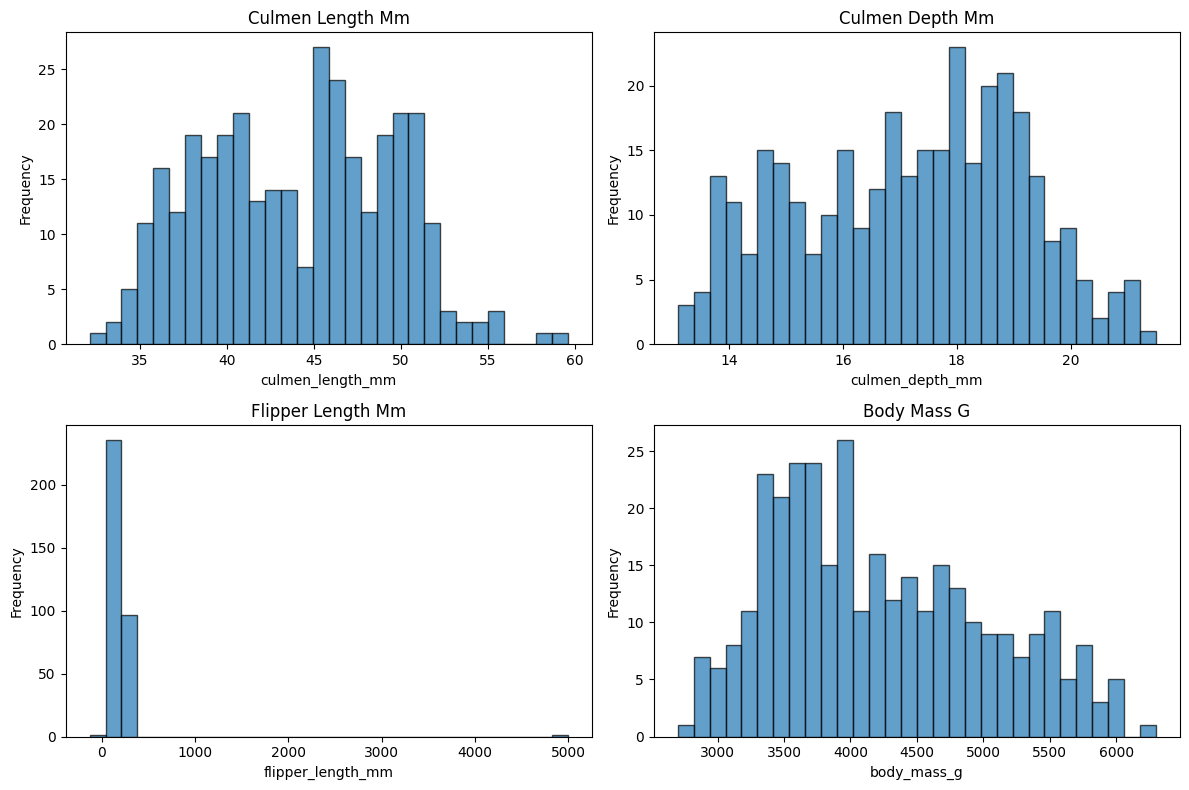

In [4]:
numeric_df = penguins_df.select_dtypes(include=[np.number])

n_cols = 2
n_rows = int(np.ceil(len(numeric_df.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

axes = axes.ravel()

for ax, col in zip(axes, numeric_df.columns):
    ax.hist(numeric_df[col], bins=30, edgecolor='black', alpha=0.7)
    ax.set_title(col.replace("_", " ").title())
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

for i in range(len(numeric_df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [5]:
penguins_df.sort_values(by='flipper_length_mm', ascending=False).head(3)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
7,42.0,20.2,5000.0,4250.0,MALE
277,54.3,15.7,231.0,5650.0,MALE
216,50.0,16.3,230.0,5700.0,MALE


In [6]:
penguins_df.sort_values(by='flipper_length_mm', ascending=True).head(3)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
10,34.6,21.1,-132.0,4400.0,MALE
24,37.9,18.6,172.0,3150.0,FEMALE
16,37.8,18.3,174.0,3400.0,FEMALE


In [7]:
#Loại bỏ các Outliners 
penguins_df = penguins_df[penguins_df['flipper_length_mm'] != 5000.0]
penguins_df = penguins_df[penguins_df['flipper_length_mm'] != -132.0]

## Chuẩn bị dữ liệu cho mô hình K-Means 

In [8]:
df = pd.get_dummies(penguins_df).drop("sex_.", axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(df)
penguins_preprocessed = pd.DataFrame(data=X, columns=df.columns)
penguins_preprocessed.head(10)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,-0.905520,0.793126,-1.428125,-0.569709,-0.991031,0.997001
1,-0.831938,0.128503,-1.071522,-0.507579,1.009050,-1.003008
2,-0.684775,0.435252,-0.429637,-1.191006,1.009050,-1.003008
3,-1.347011,1.099875,-0.572278,-0.942487,1.009050,-1.003008
4,-0.868729,1.764498,-0.786240,-0.693968,-0.991031,0.997001
5,-0.942311,0.333002,-1.428125,-0.725033,1.009050,-1.003008
6,-0.887125,1.253249,-0.429637,0.579691,-0.991031,0.997001
7,-0.537611,0.230753,-1.356804,-1.253136,1.009050,-1.003008
8,-0.997497,2.071247,-0.714919,-0.507579,-0.991031,0.997001
9,-1.365406,0.333002,-1.142843,-0.631839,1.009050,-1.003008


## Thực hiện phép phân tích thành phần chính


In [9]:
pca = PCA(n_components=None)
dfx_pca = pca.fit(penguins_preprocessed)
dfx_pca.explained_variance_ratio_
n_components = sum(dfx_pca.explained_variance_ratio_ > 0.1)
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)
print(n_components)

2


## Tìm số cluster tối ưu cho mô hình K-Means 

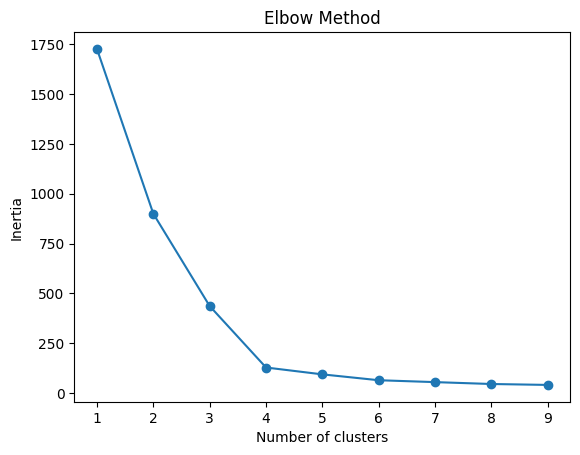

In [10]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(penguins_PCA)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 10), inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

## Xây dựng thuật toán K-Means với số cluster tối ưu = 4

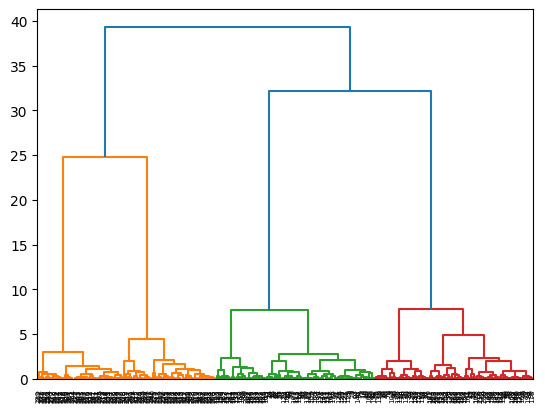

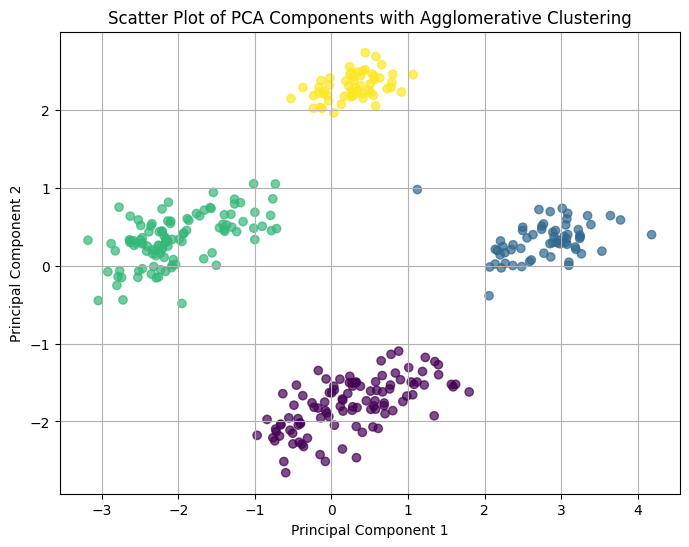

In [16]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage


mergings = linkage(penguins_PCA, method="ward", metric='euclidean')
dendrogram(mergings)
plt.show()

ward_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward').fit(penguins_PCA)
cluster_labels = ward_clustering.labels_

# Prepare data for scatter plot with colors based on clusters
df_scatter = pd.DataFrame({'PC1': penguins_PCA[:, 0], 'PC2': penguins_PCA[:, 1], 'cluster': cluster_labels})

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_scatter['PC1'], df_scatter['PC2'], c=cluster_labels,cmap="viridis", alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PCA Components with Agglomerative Clustering')
plt.grid(True)
plt.show()
